# Principal component analysis of the dataset
## 1. Library imports and setup

In [2]:
library(tidyverse)
library(xgboost)
library(pROC)

#### Determining the dpi and the image output path for publication high quality plots

In [3]:
dpi.opt <- 1000

In [4]:
IMG.path <- "../../IMG"

In [5]:
theme_set(theme_bw())

In [6]:
#flag.make.plots <- TRUE
flag.make.plots <- FALSE

## 2. Import of the clean data

In [7]:
data.path <- "../../data"

file.name <- "df_v_merged.rds"
df.v.merged <- readRDS(paste0(data.path,"/",file.name))
head(df.v.merged)


file.name <- "df_chem_merged.rds"
df.chem.merged <- readRDS(paste0(data.path,"/",file.name))
head(df.chem.merged)

,date_time,speed,heading,velocityN,velocityE,depth,site,kelp,m.yr.factor,w.yr.factor,depth.raw
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<fct>,<fct>,<ord>,<ord>,<fct>
1,2021-08-13 00:00:00,1.89,180.44,-1.89,-0.01,7 [m],GF,FALSE,Aug21,W33-21,7
2,2021-08-13 00:05:00,1.64,177.22,-1.63,0.08,7 [m],GF,FALSE,Aug21,W33-21,7
3,2021-08-13 00:10:00,1.85,177.76,-1.85,0.07,7 [m],GF,FALSE,Aug21,W33-21,7
4,2021-08-13 00:15:00,1.88,179.00,-1.88,0.03,7 [m],GF,FALSE,Aug21,W33-21,7
5,2021-08-13 00:20:00,2.12,200.43,-1.99,-0.74,7 [m],GF,FALSE,Aug21,W33-21,7
6,2021-08-13 00:25:00,2.50,210.17,-2.16,-1.26,7 [m],GF,FALSE,Aug21,W33-21,7


,ix,date_time,ec,temp,light,oxygen,pH,water_level,chlorophyll.a,chlorophyll.red,⋯,pH.upd,light.upd,salinity.upd,sensor.depth,depth,kelp,site,m.yr.factor,w.yr.factor,water.depth
,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<fct>,<fct>,<ord>,<ord>,<dbl>
1,7m_G-1,2021-08-12 08:00:00,31194.1,4.71,688.9,13.50,8.35,216.510,6,11,⋯,NA,NA,NA,NA,7 [m],FALSE,GF,Aug21,W32-21,NA
2,7m_G-2,2021-08-12 08:30:00,31219.2,4.32,667.4,13.54,8.34,216.356,8,21,⋯,NA,NA,NA,NA,7 [m],FALSE,GF,Aug21,W32-21,NA
3,7m_G-3,2021-08-12 09:00:00,31319.6,5.29,796.5,13.31,8.35,179.936,6,54,⋯,NA,NA,NA,NA,7 [m],FALSE,GF,Aug21,W32-21,8.068685
4,7m_G-4,2021-08-12 09:30:00,31323.7,5.38,1097.9,13.21,8.36,180.658,7,38,⋯,NA,NA,NA,NA,7 [m],FALSE,GF,Aug21,W32-21,8.140133
5,7m_G-5,2021-08-12 10:00:00,31246.3,4.95,602.8,13.34,8.35,181.589,6,24,⋯,NA,NA,NA,NA,7 [m],FALSE,GF,Aug21,W32-21,8.232264
6,7m_G-6,2021-08-12 10:30:00,31267.2,5.50,699.7,13.21,8.36,182.965,7,38,⋯,NA,NA,NA,NA,7 [m],FALSE,GF,Aug21,W32-21,8.368431


### 3. Building XGBoost model for predicting the presence of the kelp forest
#### Merging data frames using common timestep

In [8]:
df.velocity.30min <-  df.v.merged %>%
  mutate(date_time = floor_date(date_time, unit = "30 min")) %>%
  group_by(site,depth,date_time) %>%
  summarise(speed = mean(speed, na.rm = TRUE),
            velocityN = mean(velocityN, na.rm = TRUE),
            velocityE = mean(velocityE, na.rm = TRUE))

head(df.velocity.30min)

`summarise()` has grouped output by 'site', 'depth'. You can override using the
`.groups` argument.


site,depth,date_time,speed,velocityN,velocityE
<fct>,<ord>,<dttm>,<dbl>,<dbl>,<dbl>
GF,7 [m],2021-08-13 00:00:00,1.9800000,-1.9000000,-0.3050000
GF,7 [m],2021-08-13 00:30:00,2.6933333,-1.2816667,1.6366667
GF,7 [m],2021-08-13 01:00:00,1.9000000,-1.0533333,0.1516667
GF,7 [m],2021-08-13 01:30:00,0.9383333,-0.3400000,-0.2950000
GF,7 [m],2021-08-13 02:00:00,1.5500000,0.5566667,-1.1600000
GF,7 [m],2021-08-13 02:30:00,2.3283333,1.3450000,-1.6650000


In [9]:
df.all2 <- merge(x=df.chem.merged, y= df.velocity.30min, by=c("site","depth","date_time"))
df.all2$ix <- NULL
head(df.all2)

,site,depth,date_time,ec,temp,light,oxygen,pH,water_level,chlorophyll.a,⋯,light.upd,salinity.upd,sensor.depth,kelp,m.yr.factor,w.yr.factor,water.depth,speed,velocityN,velocityE
,<fct>,<ord>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<fct>,<ord>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>
1,GF,10 [m],2021-08-13 00:00:00,30120.4,5.25,64.6,13.17,8.37,NA,NA,⋯,64.6,32.9891,NA,FALSE,Aug21,W32-21,NA,2.918333,-1.3650000,2.348333
2,GF,10 [m],2021-08-13 00:30:00,30095.0,5.14,64.6,13.14,8.36,NA,NA,⋯,64.6,33.0673,NA,FALSE,Aug21,W33-21,NA,2.253333,0.4533333,2.181667
3,GF,10 [m],2021-08-13 01:00:00,30007.3,4.85,53.8,13.27,8.37,NA,NA,⋯,53.8,33.2496,NA,FALSE,Aug21,W33-21,NA,1.998333,0.9583333,1.751667
4,GF,10 [m],2021-08-13 01:30:00,30032.6,4.85,64.6,13.30,8.36,NA,NA,⋯,64.6,33.2807,NA,FALSE,Aug21,W33-21,NA,1.965000,1.2016667,1.550000
5,GF,10 [m],2021-08-13 02:00:00,29995.6,4.84,118.4,13.36,8.37,NA,NA,⋯,118.4,33.2453,NA,FALSE,Aug21,W33-21,NA,2.088333,1.4533333,1.441667
6,GF,10 [m],2021-08-13 02:30:00,30011.2,4.80,226.0,13.39,8.37,NA,NA,⋯,226.0,33.3047,NA,FALSE,Aug21,W33-21,NA,2.038333,1.8116667,0.740000


#### Choosing features and target

In [10]:
featX <- c('oxygen','pH',"ec",'temp','light','velocityN','velocityE')
tmp.df <- na.omit(df.all2[c(featX,"kelp","site","depth","w.yr.factor")])
X <- tmp.df[featX]
Y <- tmp.df['kelp']

#### Dividing dataset into training and test datasets

In [11]:
set.seed(2025) # setting random seed for reproducibility of the outcomes

In [12]:
n <- nrow(X)
train.ix <- sample(1:n, as.integer(0.7*n), replace=FALSE)
test.ix <- (1:n)[-train.ix]

trainX <- as.matrix(X[train.ix,])
testX <- as.matrix(X[test.ix,])

trainY <- as.matrix(as.integer(Y[train.ix,])-1)
testY <- as.matrix(as.integer(Y[test.ix,])-1)

nrow(trainX)
nrow(testX)

[1] 172564

[1] 73956

#### Training a model

In [13]:
xgb.model <- xgboost(data = trainX, label = trainY, objective = "binary:logistic", 
                     max.depth = 8, eta = 0.1,gamma=1, nthread = 4, nrounds = 200, subsample=0.5, verbose = 0)

#### Evaluation of the model

In [14]:
predP <- predict(xgb.model, testX)
pY <- as.integer( predP > 0.26)
table(data.frame(testY,pY))

     pY
testY     0     1
    0 60310   933
    1   137 12576

In [15]:
roc.obj <- roc( as.vector(testY),as.vector(predict(xgb.model, testX)))
auc(roc.obj)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.9991

In [16]:
J = roc.obj$sensitivities + roc.obj$specificities - 1
Jmax = max(J)
Jmax

[1] 0.9741941

In [17]:
roc.obj$thresholds[J == Jmax]

[1] 0.2673437

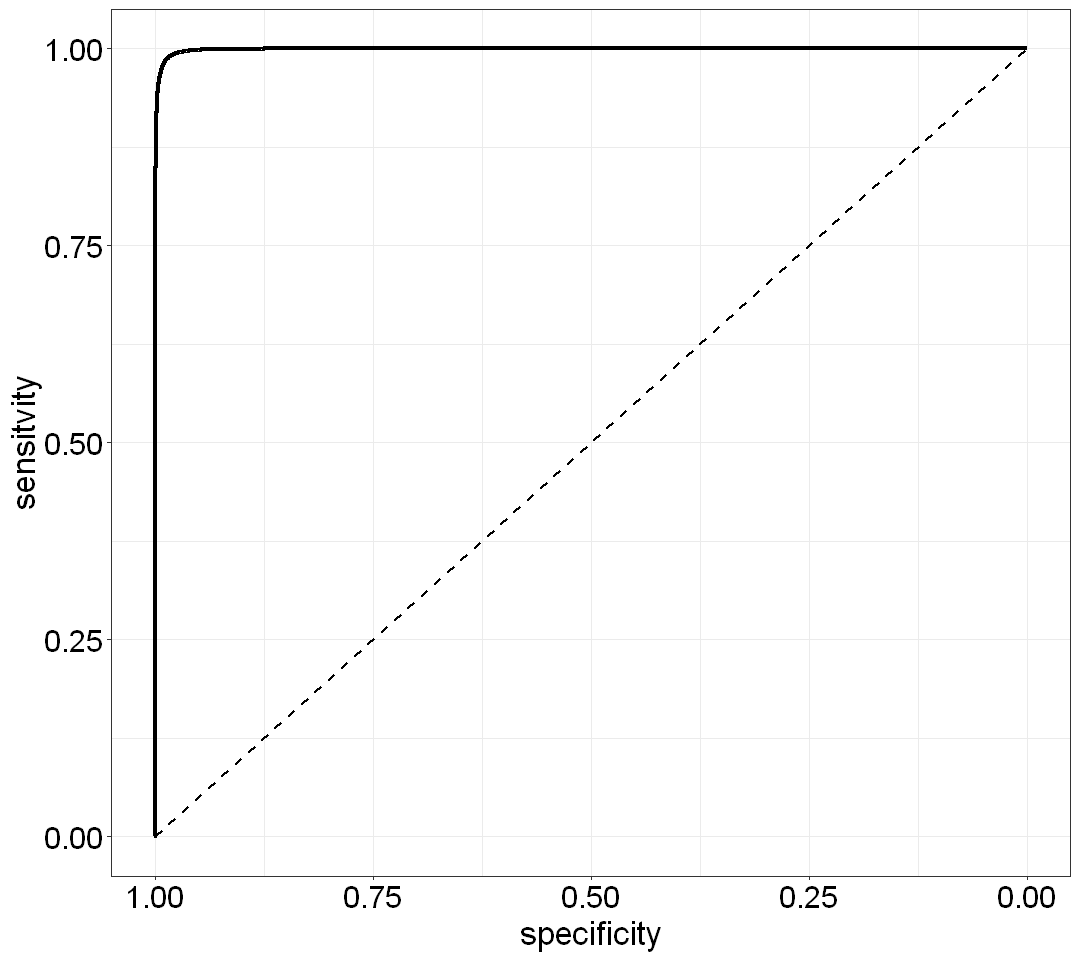

In [18]:
options(repr.plot.height=8,repr.plot.width=9)
df.roc <- data.frame(sensitvity= roc.obj$sensitivities, specificity=roc.obj$specificities)
ggplot(df.roc,aes(x=specificity, y=sensitvity)) + geom_line(linewidth=1.2) + scale_x_reverse() + 
geom_line(data=data.frame(x=c(1,0),y=c(0,1)),aes(x=x,y=y),linetype = "dashed",linewidth=0.75) +
theme(axis.text.x = element_text(size=18,colour = "black"),
      axis.text.y = element_text(size=18,colour = "black"),
      axis.title = element_text(size = 20,colour = "black"),
            legend.position="none")

if (flag.make.plots) {
    ggsave(paste0(IMG.path,"/xgb_roc.tiff"),height = 6, width = 7,dpi = dpi.opt,compression = "lzw")
}

#### Feature importance

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
ec,0.30468681,0.23160178,0.27581112
pH,0.17832506,0.22009981,0.17611252
velocityE,0.17240546,0.20757944,0.08740618
temp,0.15871498,0.13411694,0.18019030
oxygen,0.10658221,0.10214464,0.14437681
velocityN,0.04985086,0.07832686,0.09018380
light,0.02943462,0.02613052,0.04591927


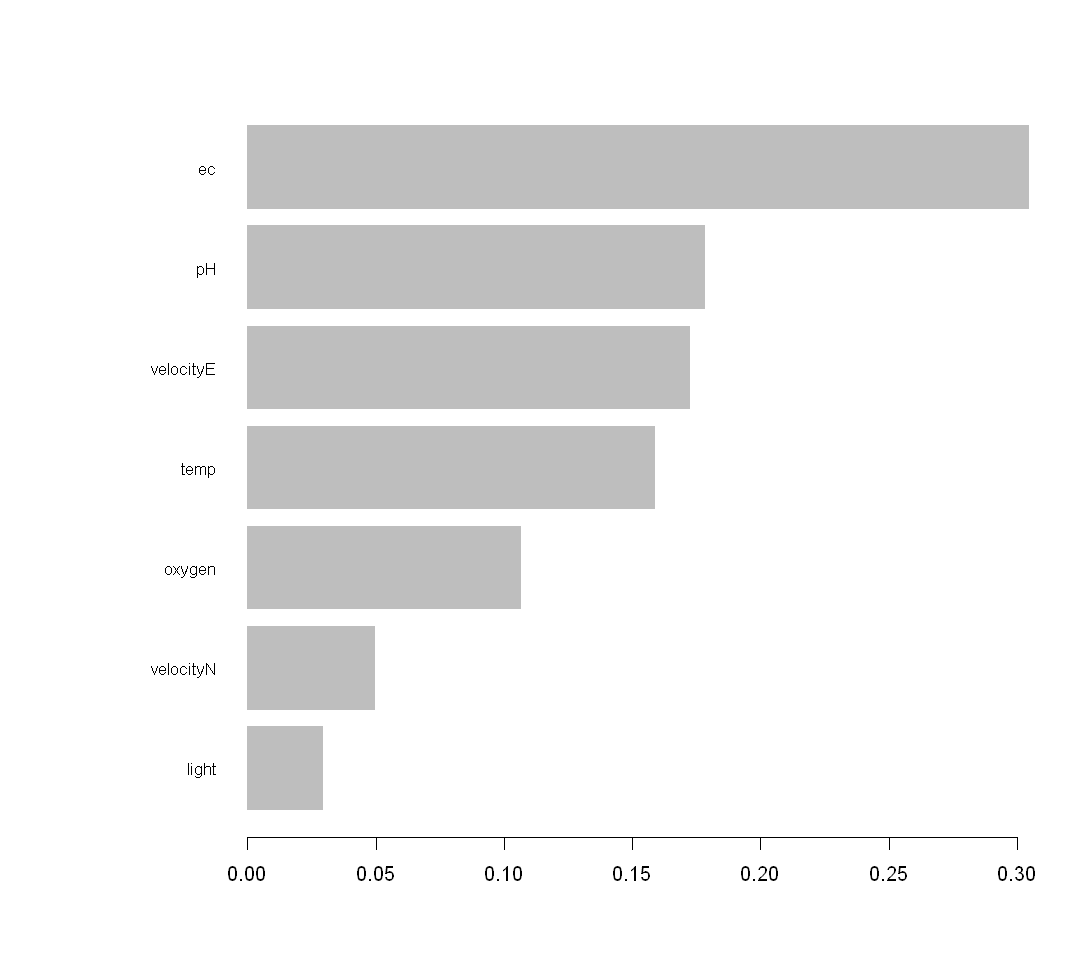

In [19]:
importance_matrix = xgb.importance(colnames(trainX), model = xgb.model)
importance_matrix
xgb.plot.importance(importance_matrix) 

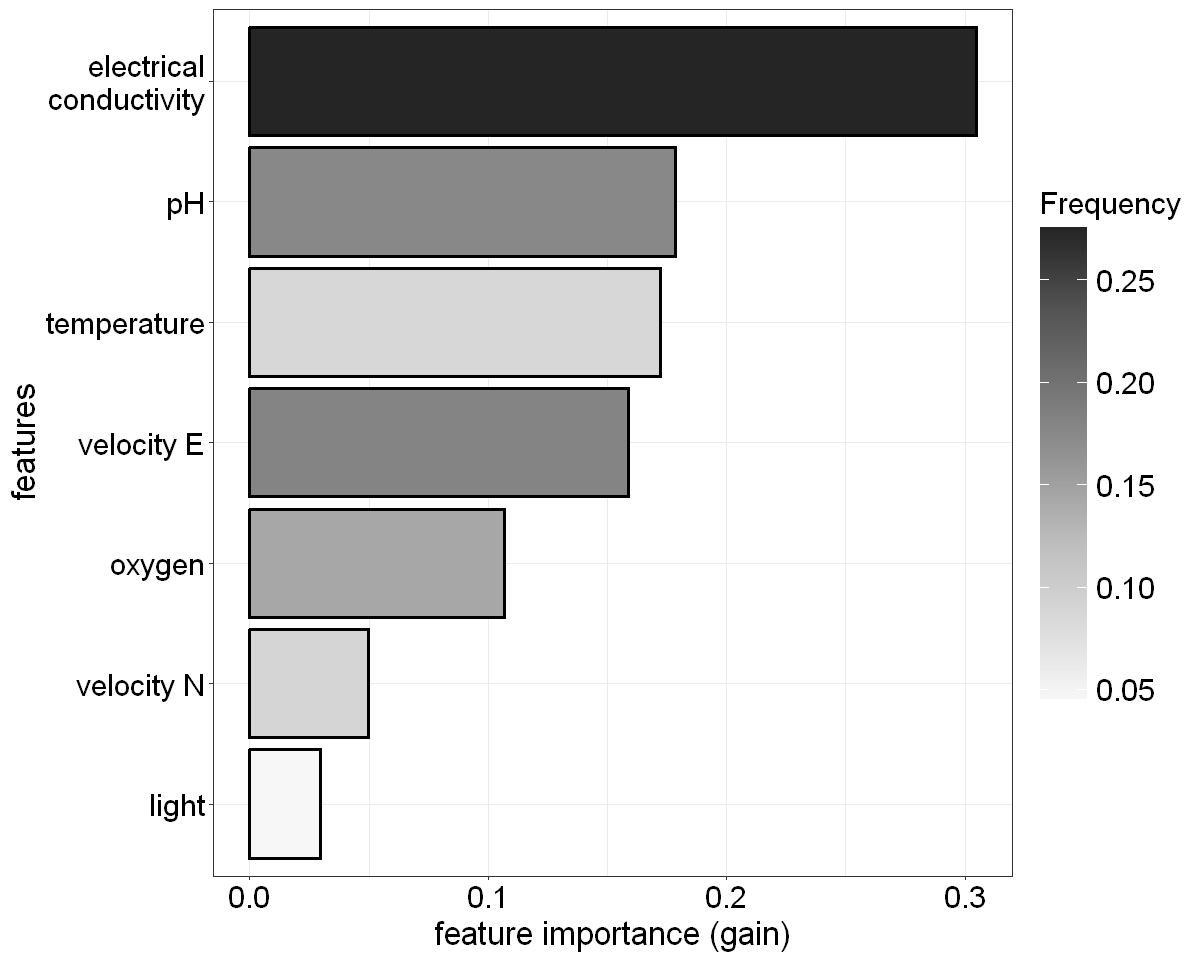

In [20]:
importance_matrix$Features <- c("electrical\nconductivity", "pH", "temperature", "velocity E", "oxygen", "velocity N", "light")


options(repr.plot.height=8,repr.plot.width=10)
ggplot(importance_matrix,aes(y=reorder(Features,Gain),x=Gain,fill=Frequency)) + geom_col(color="black",linewidth=1) + 
       scale_fill_distiller(type = "seq",direction = 1,palette = "Greys")+
xlab("feature importance (gain)") + ylab("features") +
theme(axis.text.x = element_text(size=18,colour = "black"),
      axis.text.y = element_text(size=18,colour = "black"),
      axis.title = element_text(size = 20,colour = "black"),
      #      legend.position="none"

      legend.key.size = unit(1, 'cm'), #change legend key size
      legend.key.height = unit(2, 'cm'), #change legend key height
      legend.key.width = unit(1, 'cm'), #change legend key width
      legend.title = element_text(size=18), #change legend title font size
      legend.text = element_text(size=18)      
     )

if (flag.make.plots) {
    ggsave(paste0(IMG.path,"/xgb_importnace.tiff"),height = 6, width = 8,dpi = dpi.opt,compression = "lzw")
    ggsave(paste0(IMG.path,"/xgb_importnace_small.png"),height = 6, width = 8,dpi = 300)
    ggsave(paste0(IMG.path,"/xgb_importnace_small.svg"),height = 6, width = 8)
}